# Visualizing attention on self driving car

So far we have seen many examples of attention and guided backprop on `Dense` layers that outputs a probability distribution. What if we have a regression model instead?

In this example, we will use a pretrained self driving car model that predicts the steering angle output. This model is borrowed from https://github.com/experiencor/self-driving-toy-car

Lets load the model, weights etc and make a prediction.

Predicted -0.934291124344


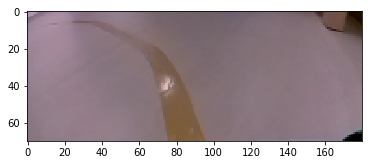

In [3]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from model import build_model, FRAME_W, FRAME_H
from keras.preprocessing.image import img_to_array
from vis.utils import utils

model = build_model()
model.load_weights('weights.hdf5')
img = utils.load_img('images/left.png', target_size=(FRAME_H, FRAME_W))
plt.imshow(img)

# Convert to BGR, create input with batch_size: 1.
bgr_img = utils.bgr2rgb(img)
img_input = np.expand_dims(img_to_array(bgr_img), axis=0)
pred = model.predict(img_input)[0][0]
print('Predicted {}'.format(pred))

Looks good. The negative value is indicative of left steering.

## Attention

Unlike attention with categorical outputs, we cannot simply take the gradient of output node with respect to inputs. If the gradient of steering output with respect to some input pixel is high, it means that a small positive change in that pixel will contribute towards increasing the output. Similarly, negative gradients indicate a decrease in output and low positive and negative gradients will not contribute much towards the change in steering output.

To handle regression use-cases in general, keras-vis provides `visualize_regression_xxx` calls. Lets try saliency and grad-CAM for this input.

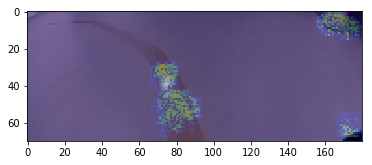

In [4]:
from vis.visualization import visualize_regression_saliency, overlay

# We want to see what would cause the current output of -0.93 to increase.
target = -0.5

heatmap = visualize_regression_saliency(model, layer_idx=-1, output_indices=0, targets=target, seed_input=bgr_img)

# Overlay is used to alpha blend heatmap onto img.
plt.imshow(overlay(img, heatmap, alpha=0.7))

Now lets see what pixels the network attents to, in order to decrease the steering or turn more left.

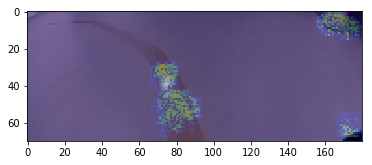

In [5]:
# We want to see what would cause the current output of -0.93 to decrease even more.
target = -1.

heatmap = visualize_regression_saliency(model, layer_idx=-1, output_indices=0, targets=target, seed_input=bgr_img)
plt.imshow(overlay(img, heatmap, alpha=0.7))

They dont look discriminative which is typical of saliency. Lets try grad-CAM.

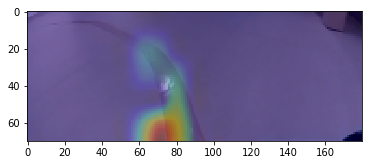

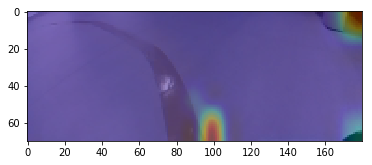

In [7]:
from vis.visualization import visualize_regression_cam

for target in [-0.5, -1.]:
    heatmap = visualize_regression_cam(model, layer_idx=-1, output_indices=0, targets=target, seed_input=bgr_img)
    plt.figure()
    plt.imshow(overlay(img, heatmap, alpha=0.7))

This makes sense. In order to turn right, the left part of the lane contributes the most towards it. I am guessing it is atteding to the fact that it curves left and so chnaging it to curve right would make the network increase the steering angle.

The other output is intuitive as well. Interestingly, The the objects in the room in the far right also provide it a cue to turn left. This means that, even without the lane marker, the network will probably turn away from obstacles.

> *This single example already provides some pretty good insight into network behavior. If your toy self driving car makes a mistake, we can easily use that example to glean why and add counter examples to the training set to correct that behavior.*